# Dataset preparation

In [1]:
import tweepy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter 
import re
import numpy as np


pd.options.display.max_colwidth = 500

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download(['punkt','stopwords'])
stopwords = stopwords.words('english')

In [3]:
twitter_consumer_key="8diq9Z2yKymfHbgFF6dlLHUaE"
twitter_consumer_secret="RcG2VTx2Hgha5zNPZnJ7HmAoh8bSTbNgvoxSuf5YFo8zZYlaoS"
twitter_access_token="1323272530619228160-ovgY32WoCMxxEmW0ewNQXYUPVJ6rqH"
twitter_access_secret = "9CsC8ZEJDcXngyRE2ThjvgIQOrtBmo9uP7xAqlpPO14lG"

In [4]:
auth = tweepy.OAuthHandler(twitter_consumer_key, twitter_consumer_secret)
auth.set_access_token(twitter_access_token, twitter_access_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

In [5]:
def get_tweets(date_since, date_until):
    tweets_list = []
    for geo_code, city_name in zip(geo_codes, city_names):
        tweets = tweepy.Cursor(
            api.search, 
            q=search_words, 
            lang="en", 
            since=date_since,
            until=date_until,
            tweet_mode='extended',
            count=250,
            include_rts = 0,
            geocode = geo_code
        ).items(250)

        for tweet in tweets:
            full_text_retweeted = tweet._json.get("retweeted_status")
            if full_text_retweeted != None:
                tweets_list.append([tweet.id_str, 
                      tweet.created_at, 
                      tweet.favorite_count, 
                      tweet.retweet_count, 
                      tweet.user.name,
                      city_name,
                      full_text_retweeted.get("full_text")])
            else:
                tweets_list.append([tweet.id_str, 
                      tweet.created_at, 
                      tweet.favorite_count, 
                      tweet.retweet_count, 
                      tweet.user.name,
                      city_name,
                      tweet._json["full_text"]])
    return tweets_list

In [6]:
search_words = "#GE2020 OR #GE20 OR #GeneralElection OR #GeneralElection2020 OR #Election2020"
dates_since = ["2020-11-0{}".format(i) for i in range(1, 8)]
dates_until = ["2020-11-0{}".format(i) for i in range(2, 9)]
language = 'en'
geo_codes = [
    "41.881832,-87.623177,100km", # Chicago
    "34.0207289,-118.6926019,100km", # Los Angeles
    "32.8208747,-96.8719694,120km", # Dallas
    "29.7632800,-95.3632700,100km" # Houston
]
city_names = ['Chicago', 'Los Angeles', 'Dallas', 'Houston']

### Create or read dataframe

Create

In [7]:
# df = pd.DataFrame()

# for date_since, date_until in zip(dates_since, dates_until):
#     tweets_list = get_tweets(date_since, date_until)
#     df_temp = pd.DataFrame(tweets_list, columns=["id","created_at","favorite_count","retweet_count","user","city","full_text"])
#     df = df.append(df_temp)
# df.reset_index(drop=True, inplace=True)

In [8]:
# df.to_csv('2020_11_12_twitts_from_cities.csv')

Read

In [9]:
df = pd.read_csv('twitts_from_cities.csv', index_col=0)

In [10]:
df.created_at = pd.to_datetime(df.created_at, format="%Y/%m/%d")
df.sort_values('created_at', inplace=True)
df.reset_index(drop=True, inplace=True)
df['day'] = df.created_at.dt.date

In [11]:
df.shape

(6996, 8)

In [12]:
df.head()

id          created_at  favorite_count  retweet_count  \
0  1322691110561632258 2020-11-01 00:05:09               0              1   
1  1322691342066212864 2020-11-01 00:06:05               0              0   
2  1322693596794003458 2020-11-01 00:15:02               7              2   
3  1322693641270370304 2020-11-01 00:15:13               0              2   
4  1322695512148086784 2020-11-01 00:22:39               0              0   

                                             user    city  \
0                                 Lee Spieckerman  Dallas   
1                                 Susana Landeira  Dallas   
2                                       KERA News  Dallas   
3  Y’all. Gracias to all that voted for Democracy  Dallas   
4                               Freida Washington  Dallas   

                                                                                                                                                                                                                           full_text  \
0  Is it plausible that the pollsters &amp; pundits are as delusional about #Election2020 as was most of Wall Street (the outliers being John Paulson &amp; @GoldmanSachs) about the housing market/CDOs in 2006? \n@POTUS @JoeBiden   
1                                                       Your vote matters. Make your voting plan for #Election2020 by finding your polling place or ballot drop box site, voting instructions, and more ⬇️\n https://t.co/CQRSzFu9BK   
2                                                                     Houston offered some 24-hour voting sites this election season. Learn more from @AP | https://t.co/HUVk9OW4dv #Election2020 #TxDecides https://t.co/mzLxmQhdsW   
3                                                                     Houston offered some 24-hour voting sites this election season. Learn more from @AP | https://t.co/HUVk9OW4dv #Election2020 #TxDecides https://t.co/mzLxmQhdsW   
4                                                                                                                                                                                        #Election2020 #ElectionDay just 2 days away   

          day  
0  2020-11-01  
1  2020-11-01  
2  2020-11-01  
3  2020-11-01  
4  2020-11-01

In [13]:
df.city.value_counts()

Chicago        1750
Los Angeles    1750
Houston        1750
Dallas         1746
Name: city, dtype: int64

# Analysis of the whole dataset

### Number of tweets in time

Tweets are not evenly spread along time, because we downloaded only 1000 tweets per each day. While limiting number of tweets per day, we get only last 1000 tweets per each day.

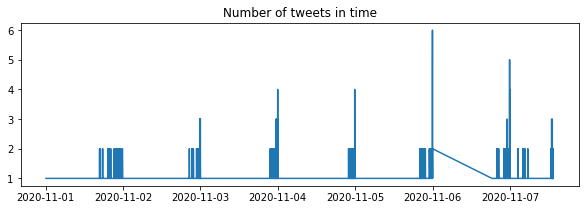

In [14]:
plt.figure(figsize=(10,3))
plt.plot(df.groupby('created_at').size())
plt.title('Number of tweets in time')
plt.show()

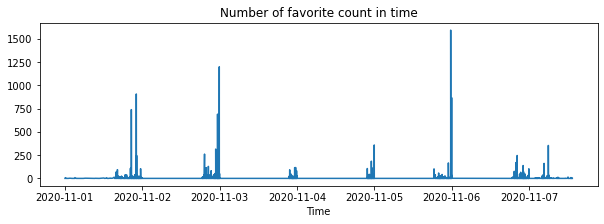

In [15]:
plt.figure(figsize=(10,3))
plt.plot(df.created_at, df.sort_values('created_at').favorite_count)
plt.title('Number of favorite count in time')
plt.xlabel('Time')
plt.show()

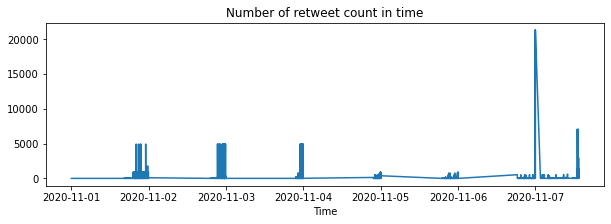

In [16]:
plt.figure(figsize=(10,3))
plt.plot(df.created_at, df.sort_values('created_at').retweet_count)
plt.title('Number of retweet count in time')
plt.xlabel('Time')
plt.show()

### Other hashtags

In [17]:
hashtags_basic = ['#GE2020', '#GE20', '#GeneralElection', '#GeneralElection2020', '#Election2020']

In [18]:
hashtags=[]
for txt in df['full_text']:
    hashtags.append([t.strip("#") for t in txt.split() if t.startswith("#") and t not in hashtags_basic])

In [19]:
df['other_hashtags_number'] = [len(x) for x in hashtags]

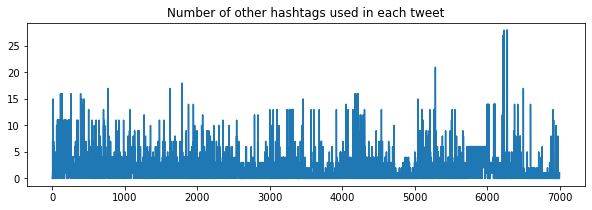

In [20]:
plt.figure(figsize=(10,3))
plt.plot(df.other_hashtags_number)
plt.title('Number of other hashtags used in each tweet')
plt.show()

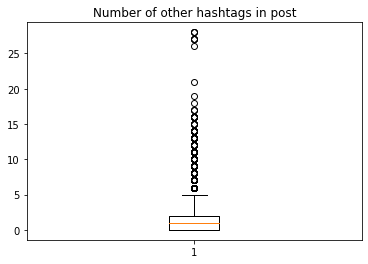

In [21]:
plt.boxplot(df.other_hashtags_number)
plt.title('Number of other hashtags in post')
plt.show()

Majority of tweets contain only few or none other hashtags - it can be seen on the boxplot. On the line plot we see that posts with many hashtags are distributed quite evenly.

### Most popular words

In [22]:
df['full_text_lower'] = df.full_text.str.lower()

In [23]:
text_cleaned_tokenized = []
for text in df.full_text_lower:
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text_cleaned_tokenized.append([word for word in word_tokenize(text) if (word not in stopwords and word.isalpha())])

In [24]:
df['text_cleaned_tokenized'] = text_cleaned_tokenized

In [25]:
df['text_cleaned'] = df['text_cleaned_tokenized'].apply(lambda x: ' '.join(x))

In [26]:
all_tweets_text = ' '.join(df.text_cleaned)

In [27]:
all_tweets_split = all_tweets_text.split()

In [28]:
word_count = Counter(all_tweets_split)

In [29]:
word_count.most_common(10)

[('vote', 1652),
 ('biden', 1239),
 ('election', 843),
 ('trump', 685),
 ('one', 670),
 ('electionday', 657),
 ('arizona', 640),
 ('votes', 553),
 ('voting', 546),
 ('america', 528)]

In [30]:
wordcloud = WordCloud(width=1000, height=600)
wordcloud.generate(all_tweets_text)

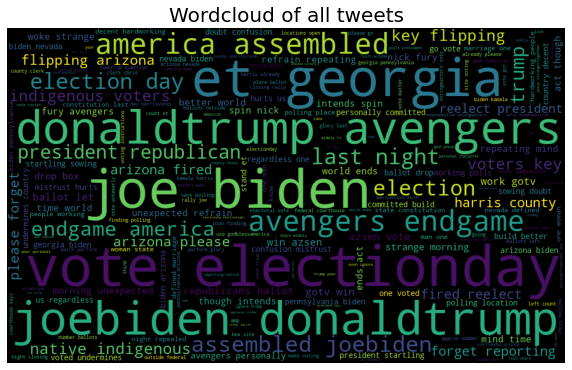

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Wordcloud of all tweets', fontsize=20)
plt.show()

### Sentiment

In [32]:
df['sentiment'] = df.text_cleaned.apply(lambda x: TextBlob(x).sentiment[0])

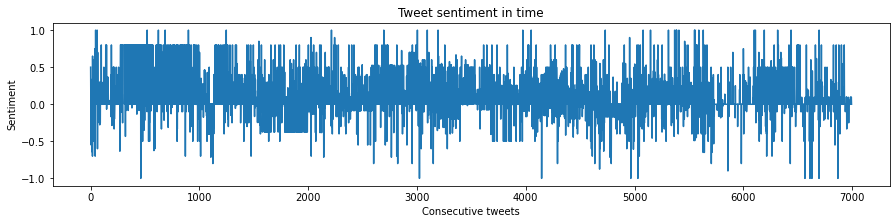

In [33]:
plt.figure(figsize=(15, 3))
plt.plot(df.sentiment)
plt.title('Tweet sentiment in time')
plt.xlabel('Consecutive tweets')
plt.ylabel('Sentiment')
plt.show()

# Analysis of the dataset by candidate mentioned

In [34]:
df['biden'] = df.text_cleaned_tokenized.apply(lambda x: 1 if 'biden' in x or 'joebiden' in x else 0)
df['trump'] = df.text_cleaned_tokenized.apply(lambda x: 1 if 'trump' in x or 'donaldtrump' in x else 0)
df['both']  = df.biden * df.trump
df['only_biden'] = df.biden - df.both
df['only_trump'] = df.trump - df.both

In [35]:
df['mentioned'] = None
df.loc[df.only_biden == 1,'mentioned'] = 'biden'
df.loc[df.only_trump == 1, 'mentioned'] = 'trump'
df.loc[df.both == 1, 'mentioned'] = 'both'

### Number of favorite and retweet count in time 

In [36]:
df = df.sort_values('created_at')

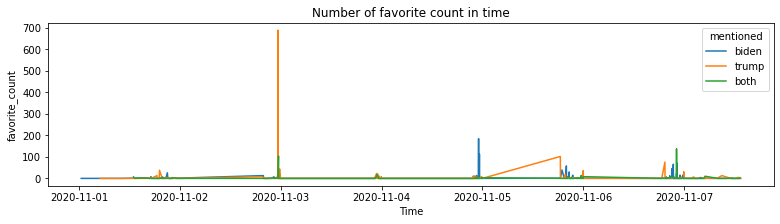

In [37]:
plt.figure(figsize=(13,3))
sns.lineplot(x='created_at', y='favorite_count', hue='mentioned', data=df)
plt.title('Number of favorite count in time')
plt.xlabel('Time')
plt.show()

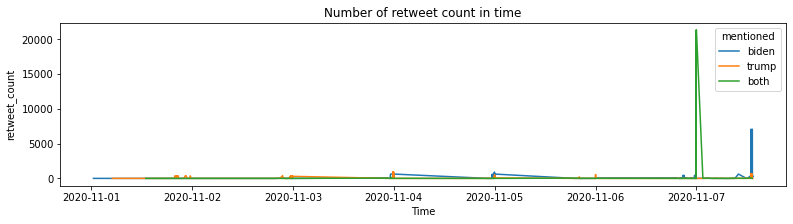

In [38]:
plt.figure(figsize=(13,3))
sns.lineplot(x='created_at', y='retweet_count', hue='mentioned', data=df)
plt.title('Number of retweet count in time')
plt.xlabel('Time')
plt.show()

There is a huge peak in retweek count around 2020-11-07, which is very intuitive, because that was the time that results were published.

### Other hashtags

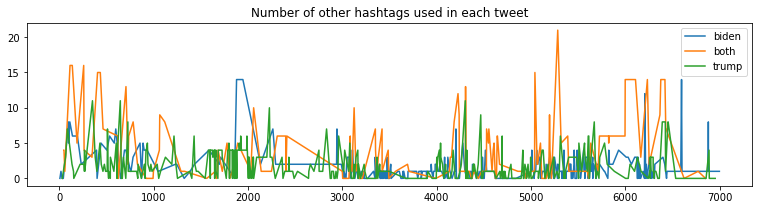

In [39]:
plt.figure(figsize=(13,3))
df.groupby('mentioned').other_hashtags_number.plot()
plt.legend()
plt.title('Number of other hashtags used in each tweet')
plt.show()

### Most popular words

In [40]:
biden_tweets_text = ' '.join(df[df.mentioned=='biden'].text_cleaned)
trump_tweets_text = ' '.join(df[df.mentioned=='trump'].text_cleaned)
both_tweets_text  = ' '.join(df[df.mentioned=='both'].text_cleaned)

In [41]:
biden_tweets_split = biden_tweets_text.split()
trump_tweets_split = trump_tweets_text.split()
both_tweets_split  = both_tweets_text.split()

In [42]:
word_count_biden = Counter(biden_tweets_split)
word_count_trump = Counter(trump_tweets_split)
word_count_both  = Counter(both_tweets_split)

In [43]:
word_count_biden.most_common(10)

[('biden', 1042),
 ('joe', 207),
 ('georgia', 186),
 ('pennsylvania', 168),
 ('nevada', 162),
 ('arizona', 145),
 ('stand', 140),
 ('vote', 137),
 ('et', 137),
 ('votes', 135)]

In [44]:
word_count_trump.most_common(10)

[('trump', 463),
 ('vote', 112),
 ('like', 109),
 ('amp', 99),
 ('even', 93),
 ('please', 87),
 ('read', 86),
 ('character', 81),
 ('poor', 81),
 ('share', 80)]

In [45]:
word_count_both.most_common(10)

[('joebiden', 258),
 ('donaldtrump', 247),
 ('america', 226),
 ('avengers', 224),
 ('endgame', 224),
 ('assembled', 223),
 ('trump', 222),
 ('biden', 197),
 ('vote', 40),
 ('election', 35)]

In [46]:
wordcloud_biden = WordCloud(width=1000, height=600)
wordcloud_biden.generate(biden_tweets_text)
wordcloud_trump = WordCloud(width=1000, height=600)
wordcloud_trump.generate(trump_tweets_text)
wordcloud_both  = WordCloud(width=1000, height=600)
wordcloud_both.generate(both_tweets_text)

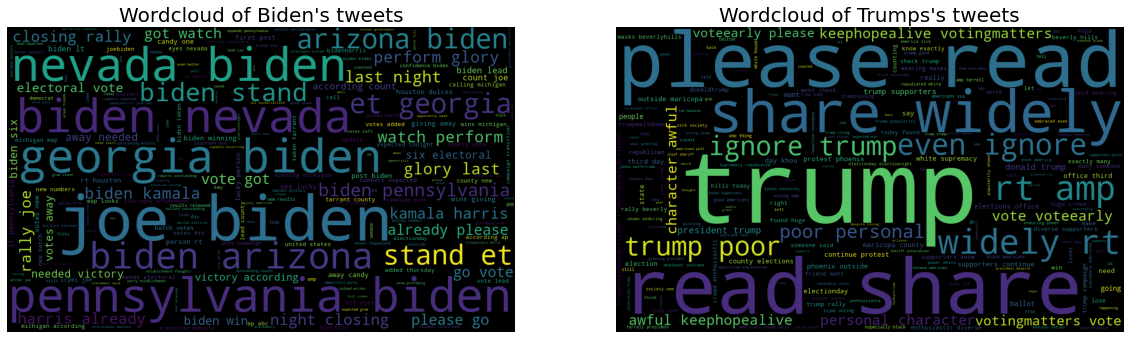

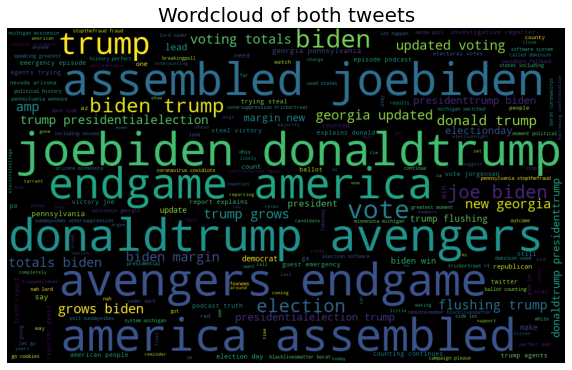

In [47]:
plt.subplots(1, 2, figsize=(20, 10))
plt.subplot(121)
plt.imshow(wordcloud_biden)
plt.axis('off')
plt.title("Wordcloud of Biden's tweets", fontsize=20)
plt.subplot(122)
plt.imshow(wordcloud_trump)
plt.axis('off')
plt.title("Wordcloud of Trumps's tweets", fontsize=20)
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_both)
plt.axis('off')
plt.title("Wordcloud of both tweets", fontsize=20)
plt.show()

We can see that posts containing Trump's name were mostly encouraging to read carefully and share the content. Biden's mentions, on the other hand, are in majority parts of tweets showing support in a given state.

What is interesting, posts containing both candidates' names were comparing elections to Avengers Endgame.

### Sentiment

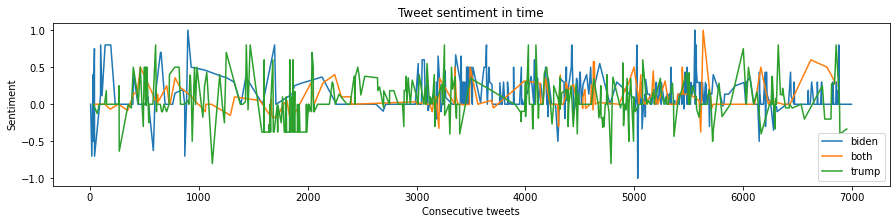

In [48]:
plt.figure(figsize=(15, 3))
df.groupby('mentioned').sentiment.plot()
plt.title('Tweet sentiment in time')
plt.xlabel('Consecutive tweets')
plt.ylabel('Sentiment')
plt.legend()
plt.show()

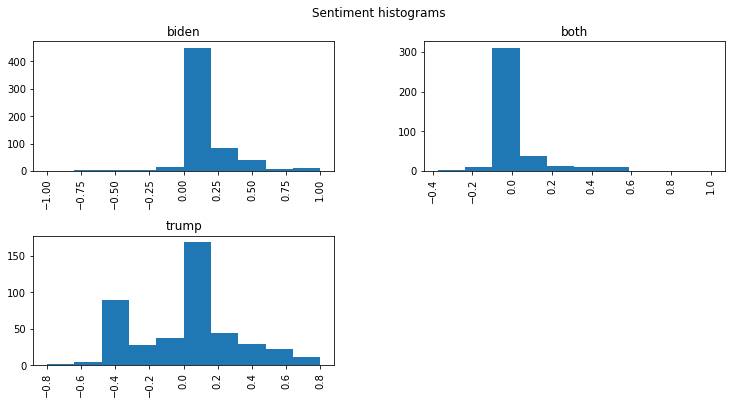

In [49]:
df.sentiment.hist(by=df.mentioned, figsize=(12, 6))
plt.suptitle('Sentiment histograms')
plt.show()

We can see that tweets about Biden are mostly neutral with some of them being positive. On the other hand, many posts about Trump are negative, which can relate to the election results. Tweets containing both of them are mostly neutral.

# Analysis of the dataset by city

### Number of favorite and retweet count in time 

In [50]:
df = df.sort_values('created_at')

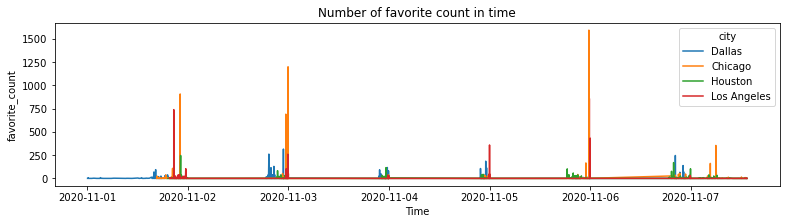

In [51]:
plt.figure(figsize=(13,3))
sns.lineplot(x='created_at', y='favorite_count', hue='city', data=df)
plt.title('Number of favorite count in time')
plt.xlabel('Time')
plt.show()

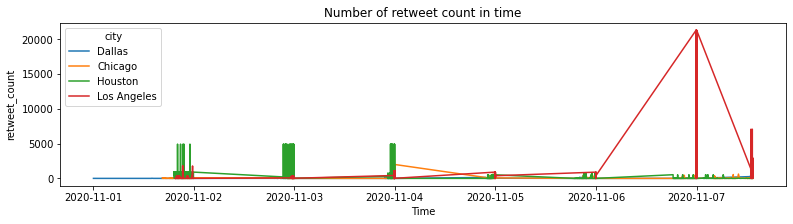

In [52]:
plt.figure(figsize=(13,3))
sns.lineplot(x='created_at', y='retweet_count', hue='city', data=df)
plt.title('Number of retweet count in time')
plt.xlabel('Time')
plt.show()

There is a huge peak in posts from Los Angeles around 2020-11-07. 

### Other hashtags

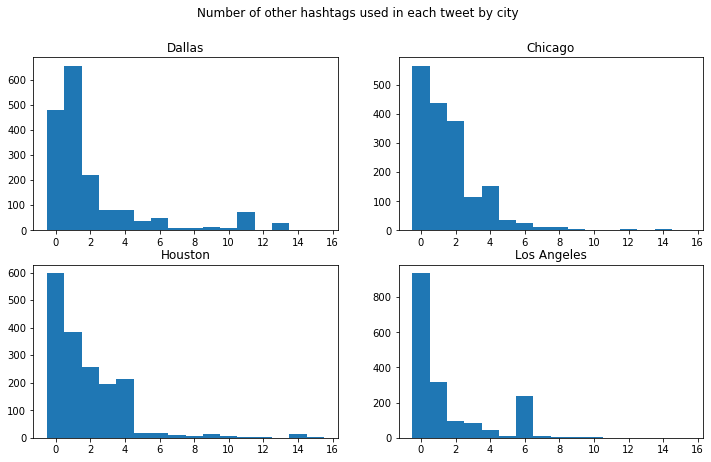

In [53]:
plt.subplots(2, 2, figsize=(12, 7))
for i, city in enumerate(df.city.unique()):
    plt.subplot(221+i)
    plt.hist(df[df.city==city].other_hashtags_number, bins=np.arange(-0.5, 16.5, 1))
    plt.title(city)
plt.suptitle('Number of other hashtags used in each tweet by city')
plt.show()

### Most popular words

In [54]:
dallas_tweets_text      = ' '.join(df[df.city=='Dallas'].text_cleaned)
chicago_tweets_text     = ' '.join(df[df.city=='Chicago'].text_cleaned)
houston_tweets_text     = ' '.join(df[df.city=='Houston'].text_cleaned)
los_angeles_tweets_text = ' '.join(df[df.city=='Los Angeles'].text_cleaned)

In [55]:
dallas_tweets_split       = dallas_tweets_text.split()
chicago_tweets_split      = chicago_tweets_text.split()
houston_tweets_split      = houston_tweets_text.split()
los_angeles_tweets_split  = los_angeles_tweets_text.split()

In [56]:
word_count_dallas = Counter(dallas_tweets_split)
word_count_chicago = Counter(chicago_tweets_split)
word_count_houston  = Counter(houston_tweets_split)
word_count_los_angeles  = Counter(los_angeles_tweets_split)

In [57]:
word_count_dallas.most_common(10)

[('biden', 788),
 ('vote', 348),
 ('georgia', 328),
 ('nevada', 324),
 ('pennsylvania', 299),
 ('et', 288),
 ('votes', 275),
 ('arizona', 263),
 ('election', 213),
 ('ballots', 205)]

In [58]:
word_count_chicago.most_common(10)

[('vote', 486),
 ('trump', 237),
 ('amp', 235),
 ('biden', 227),
 ('election', 214),
 ('please', 208),
 ('like', 180),
 ('go', 163),
 ('electionday', 141),
 ('us', 137)]

In [59]:
word_count_houston.most_common(10)

[('vote', 361),
 ('world', 320),
 ('election', 268),
 ('electionday', 260),
 ('county', 251),
 ('get', 228),
 ('let', 217),
 ('president', 200),
 ('ballot', 198),
 ('win', 192)]

In [60]:
word_count_los_angeles.most_common(10)

[('one', 464),
 ('vote', 457),
 ('america', 337),
 ('joebiden', 227),
 ('voters', 226),
 ('donaldtrump', 226),
 ('president', 224),
 ('assembled', 223),
 ('avengers', 223),
 ('endgame', 223)]

In [61]:
wordcloud_dallas = WordCloud(width=1000, height=600)
wordcloud_dallas.generate(dallas_tweets_text)
wordcloud_chicago = WordCloud(width=1000, height=600)
wordcloud_chicago.generate(chicago_tweets_text)
wordcloud_houston  = WordCloud(width=1000, height=600)
wordcloud_houston.generate(houston_tweets_text)
wordcloud_los_angeles  = WordCloud(width=1000, height=600)
wordcloud_los_angeles.generate(los_angeles_tweets_text)

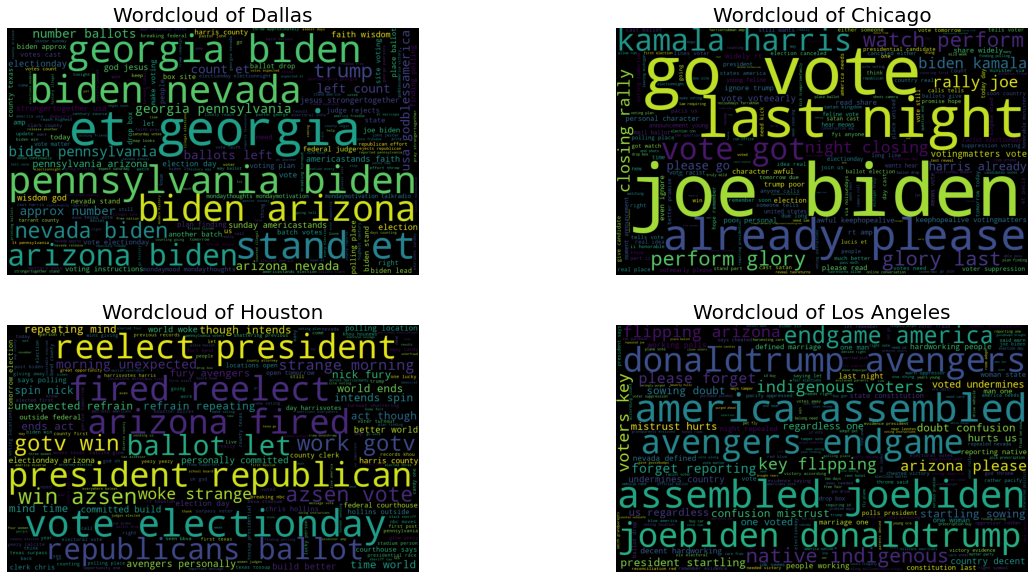

In [62]:
plt.subplots(2, 2, figsize=(20, 10))
plt.subplot(221)
plt.imshow(wordcloud_dallas)
plt.axis('off')
plt.title("Wordcloud of Dallas", fontsize=20)
plt.subplot(222)
plt.imshow(wordcloud_chicago)
plt.axis('off')
plt.title("Wordcloud of Chicago", fontsize=20)
plt.subplot(223)
plt.imshow(wordcloud_houston)
plt.axis('off')
plt.title("Wordcloud of Houston", fontsize=20)
plt.subplot(224)
plt.imshow(wordcloud_los_angeles)
plt.axis('off')
plt.title("Wordcloud of Los Angeles", fontsize=20)
plt.show()

In the elections Donald Trump won in state of Texas, so we can expect that tweets from Dallas and Houston will favour him. In Houston we can for example see "republican" and "republicans", which is Trump's political party. It follows the intuition.

On the other hand, in L.A. and Chicago Joe Biden got majority of votes. We can see many posts encouraging to vote, which is expected for a state which wants a change.

### Sentiment

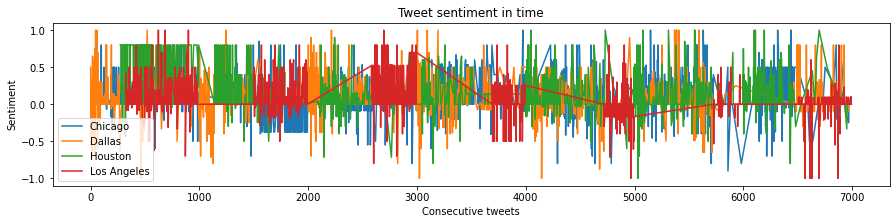

In [63]:
plt.figure(figsize=(15, 3))
df.groupby('city').sentiment.plot()
plt.title('Tweet sentiment in time')
plt.xlabel('Consecutive tweets')
plt.ylabel('Sentiment')
plt.legend()
plt.show()

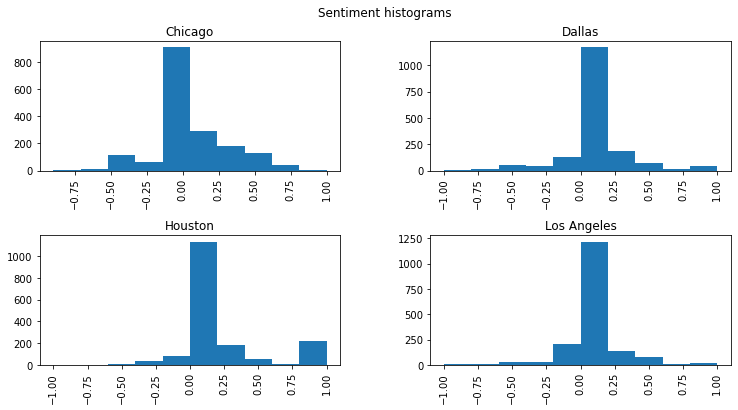

In [64]:
df.sentiment.hist(by=df.city, figsize=(12, 6))
plt.suptitle('Sentiment histograms')
plt.show()

We can't see much polarity when considering different cities.

# Map of election results

There are two states for which data was not available.

In [65]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

In [66]:
R = [
    'Alabama',
    'Alaska',
    'Arkansas',
    'Florida',
    'Idaho',
    'Indiana',
    'Iowa',
    'Kansas',
    'Kentucky',
    'Louisiana',
    'Mississippi',
    'Missouri',
    'Montana',
    'Nebraska',
    'North Dakota',
    'Ohio',
    'Oklahoma',
    'South Carolina',
    'South Dakota',
    'Tennessee',
    'Texas',
    'Utah',
    'West Virginia',
    'Wyoming'
]

In [67]:
B = [
    'Arizona',
    'California',
    'Colorado',
    'Connecticut',
    'Delaware',
    'District of Columbia',
    'Hawaii',
    'Illinois',
    'Maine',
    'Maryland',
    'Massachusetts',
    'Michigan',
    'Minnesota',
    'Nevada',
    'New Hampshire',
    'New Jersey',
    'New Mexico',
    'New York',
    'Oregon',
    'Pennsylvania',
    'Rhode Island',
    'Vermont',
    'Virginia',
    'Washington',
    'Wisconsin'
]

In [68]:
W = [
    'Georgia',
    'North Carolina'
]

In [69]:
winners = {}
for r in R:
    winners[r] = 'R'
for b in B:
    winners[b] = 'B'
for w in W:
    winners[w] = 'W'

C:\Users\jarek\.conda\envs\unstructured\lib\site-packages\cartopy\mpl\geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


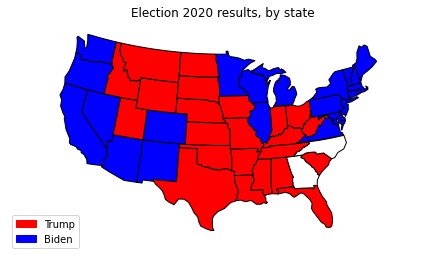

In [70]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal())
ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())
shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)

ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
edgecolor = 'black'

for astate in shpreader.Reader(states_shp).records():
    if winners[astate.attributes['name']] == 'R':
        facecolor='red'
    elif winners[astate.attributes['name']] == 'B':
        facecolor='blue'
    else:
        facecolor='white'
    ax.add_geometries([astate.geometry], ccrs.PlateCarree(),
                      facecolor=facecolor, edgecolor=edgecolor)
plt.title('Election 2020 results, by state')
red  = mpatches.Patch(color='red', label='Trump')
blue = mpatches.Patch(color='blue', label='Biden')
plt.legend(handles=[red,blue], loc='lower left')
plt.show()